# Feature Engineering and XGBoost

In this notebook, I used an XGBoost regressor modeling alongside the creation of new features and an Analysis to avoid overfitting the prediction model.

The main libraries are NumPy, pandas, seaborn, and matplotlib. Also, I used the train_test_split function from sklearn to split the train data into train and validation sets.

# Initial dataframe analysis

Initially, the main libraries were exported alongside the location of the files in the current Kaggle interface.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


Then, I analyzed the train data, where I checked the different categories from the columns that had strings as values:

1. Country
2. Store
3. Product

In [2]:
train=pd.read_csv("/kaggle/input/tabular-playground-series-sep-2022/train.csv")
train.shape

(70128, 6)

In [3]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [4]:
train["country"].unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

In [5]:
train["store"].unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [6]:
train["product"].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In this dataframe are six countries, two stores, and 4 books. Also, it is important to say that there are not null values, something that makes it easier to construct the modeling.

Then, for checking if the test data set has the same categorical data the previous analysis was repeated:

In [8]:
train["date"]=pd.to_datetime(train["date"])

In [9]:
test=pd.read_csv("/kaggle/input/tabular-playground-series-sep-2022/test.csv")

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   17520 non-null  int64 
 1   date     17520 non-null  object
 2   country  17520 non-null  object
 3   store    17520 non-null  object
 4   product  17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB


In [11]:
test["country"].unique()

array(['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain'],
      dtype=object)

In [12]:
test["store"].unique()

array(['KaggleMart', 'KaggleRama'], dtype=object)

In [13]:
test["product"].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

As expected, the test dataframe has the same categories as the training dataset.

# Initial plots

After the initial dataframe analysis, I built the following plots where in order represent the following trends:

1. Daily total sales per country
2. Daily total sales per store
3. Daily total sales per product

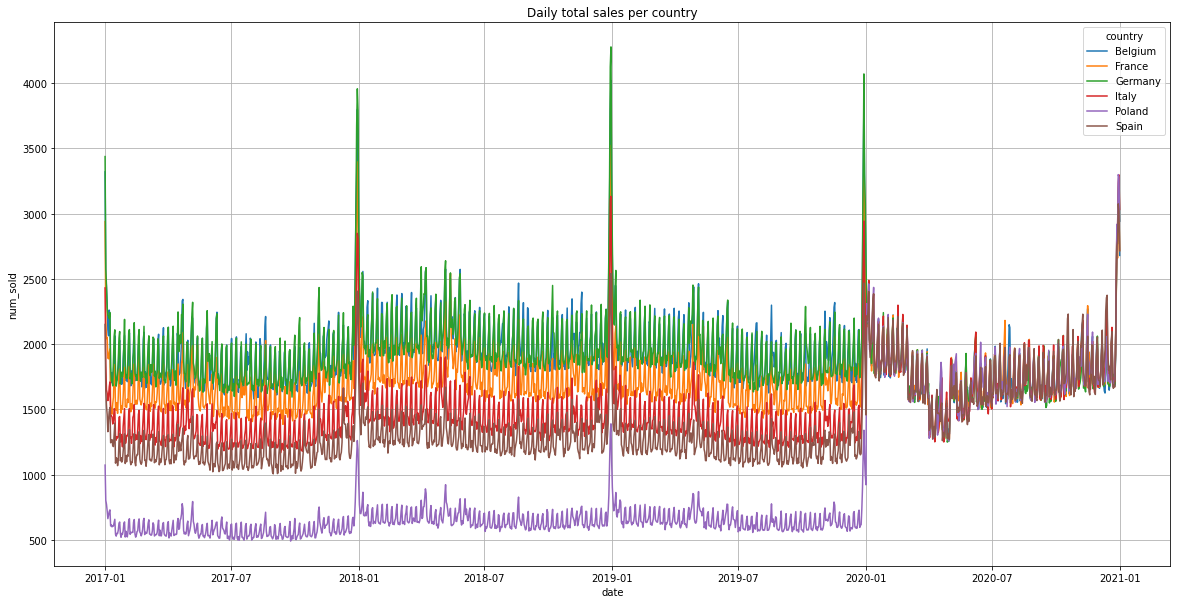

In [14]:
plt.figure(figsize=(20,10))
plt.grid()
plot1=train.groupby(by=["date","country"]).sum().reset_index()
sns.lineplot(data=plot1,x="date",y="num_sold",hue="country")
plt.title("Daily total sales per country");

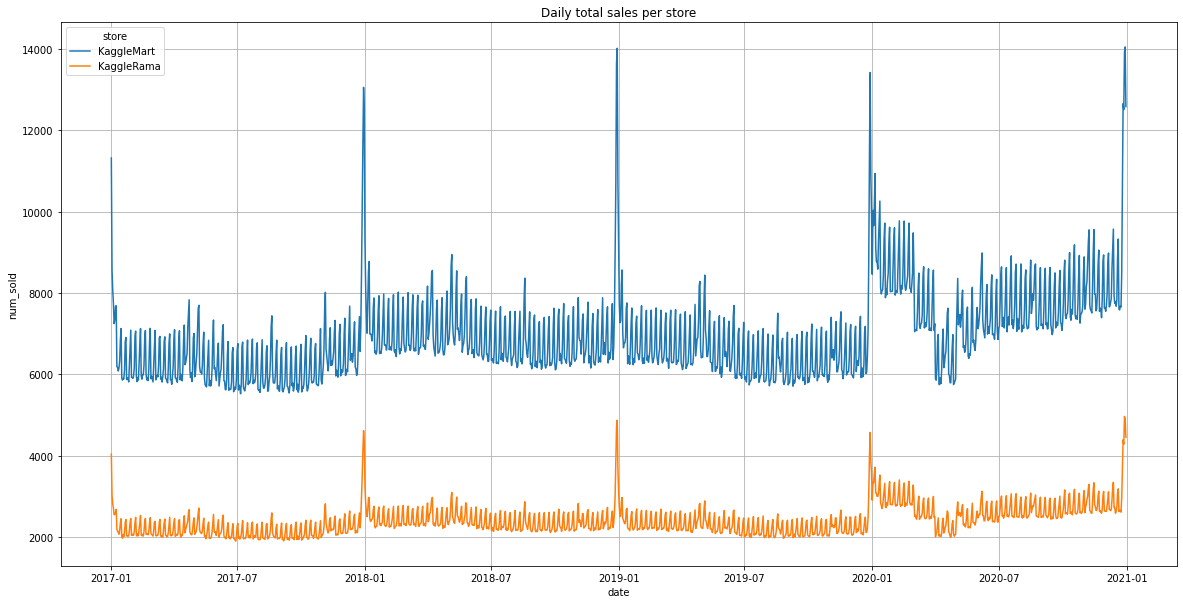

In [15]:
plt.figure(figsize=(20,10))
plt.grid()
plot2=train.groupby(by=["date","store"]).sum().reset_index()
sns.lineplot(data=plot2,x="date",y="num_sold", hue="store")
plt.title("Daily total sales per store");

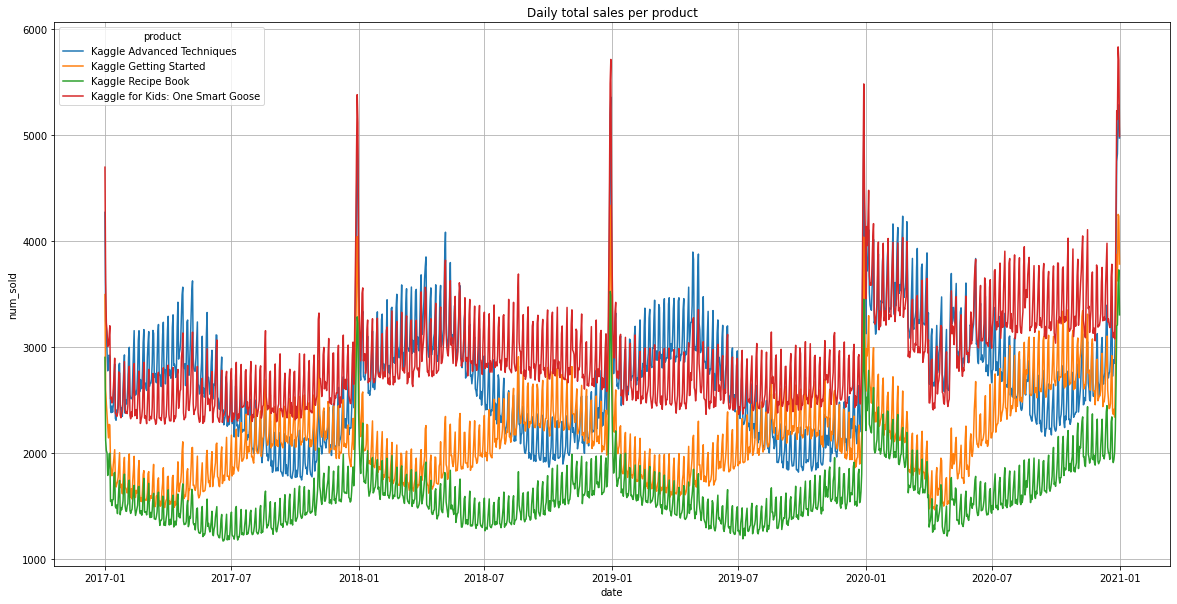

In [16]:
plt.figure(figsize=(20,10))
plt.grid()
plot2=train.groupby(by=["date","product"]).sum().reset_index()
sns.lineplot(data=plot2,x="date",y="num_sold", hue="product")
plt.title("Daily total sales per product");

With these plots the following remarks were found:

1. After 2020 the sales per country are very similar, following the same trend
2. In all the plots there is an increment in sales near new year's eve
3. Between March and June of 2020 there is a decrement in total sales product of the lockdowns in these countries
4. Each store follows a similar trend but with different total amounts of sales
5. The Book sales per product have their own time trends
6. The day of week and month seem to be relevant for the sales

# Feature Engineering

With the conclusion from these plots, both train and test dataframes were updated with the following data, created from the `date` column:

1. Day
2. Day of week (Monday to Sunday)
3. Month
4. Year
5. Quarter
6. Lockdown (Data from March to June of 2020)


In [17]:
#Train
train["date"]=pd.to_datetime(train["date"])
train["day of week"] = train["date"].dt.dayofweek
train["day"] = train["date"].dt.day
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year
train["quarter"] = train["date"].dt.quarter
#Lockdown checking
pandemy=[]
for i in range(len(train)):
    if train["year"][i] == 2020 and train["month"][i] in [3,4,5,6]:
        pandemy.append(True)
    else:
        pandemy.append(False)
train["lockdown"] = pandemy
#Test
test["date"]=pd.to_datetime(test["date"])
test["day of week"] = test["date"].dt.dayofweek
test["day"] = test["date"].dt.day
test["month"] = test["date"].dt.month
test["year"] = test["date"].dt.year #Extra
test["lockdown"] = False
test["quarter"] = test["date"].dt.quarter

In [18]:
# Converting object columns to category
for i in train.columns:
    if train[i].dtype == 'O':
        train[i]=train[i].astype("category")
for i in test.columns:
    if test[i].dtype == 'O':
        test[i]=test[i].astype("category")       

With these new data, the following boxplots are presented:

1. Total sales per day of week
2. Total sales per month

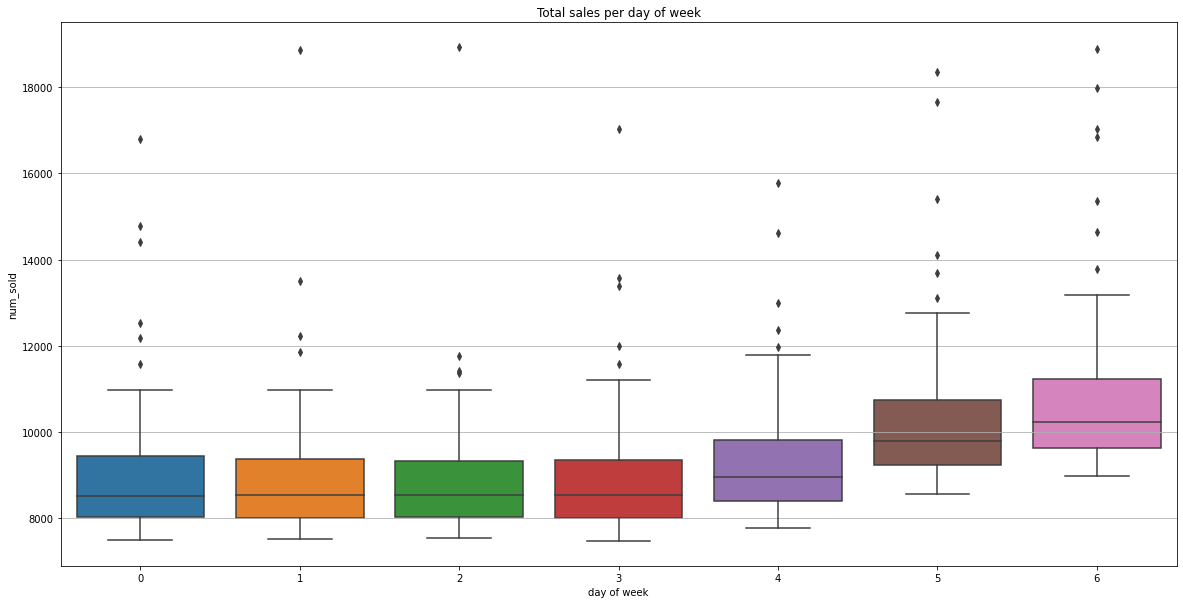

In [19]:
plt.figure(figsize=(20,10))
plt.grid()
plot3=train.groupby(by=["date","day of week"]).sum().reset_index()
sns.boxplot(data=plot3,x="day of week",y="num_sold")
plt.title("Total sales per day of week");

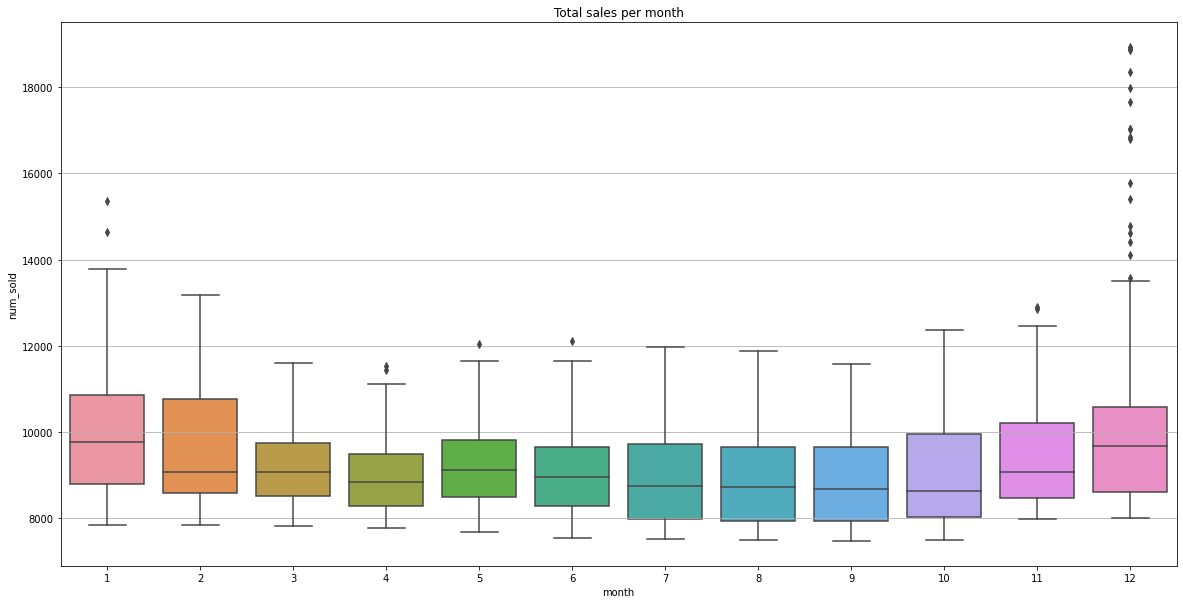

In [20]:
plt.figure(figsize=(20,10))
plt.grid()
plot3=train.groupby(by=["date","month"]).sum().reset_index()
sns.boxplot(data=plot3,x="month",y="num_sold")
plt.title("Total sales per month");

In complement, the following plots show the following relations during the lockdown period:

1. Daily total sales per country
2. Daily total sales per store
3. Daily total sales per product
4. Total sales per day of the week

In [21]:
Pandemy_on=train[train["lockdown"]==True]

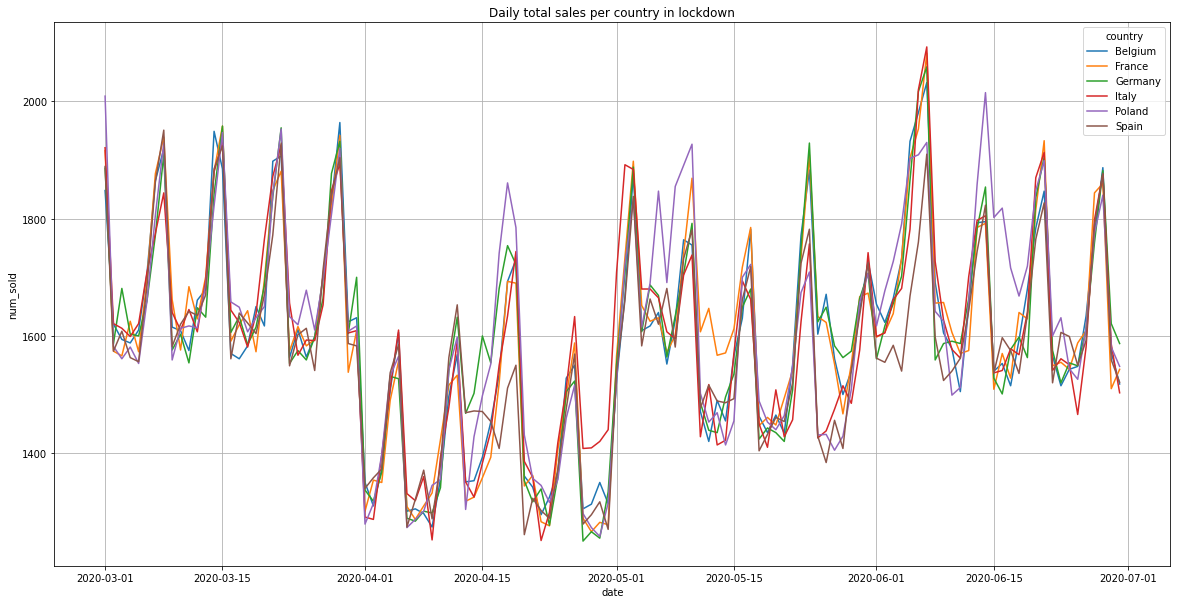

In [22]:
plt.figure(figsize=(20,10))
plt.grid()
plot1=Pandemy_on.groupby(by=["date","country"]).sum().reset_index()
sns.lineplot(data=plot1,x="date",y="num_sold",hue="country")
plt.title("Daily total sales per country in lockdown");

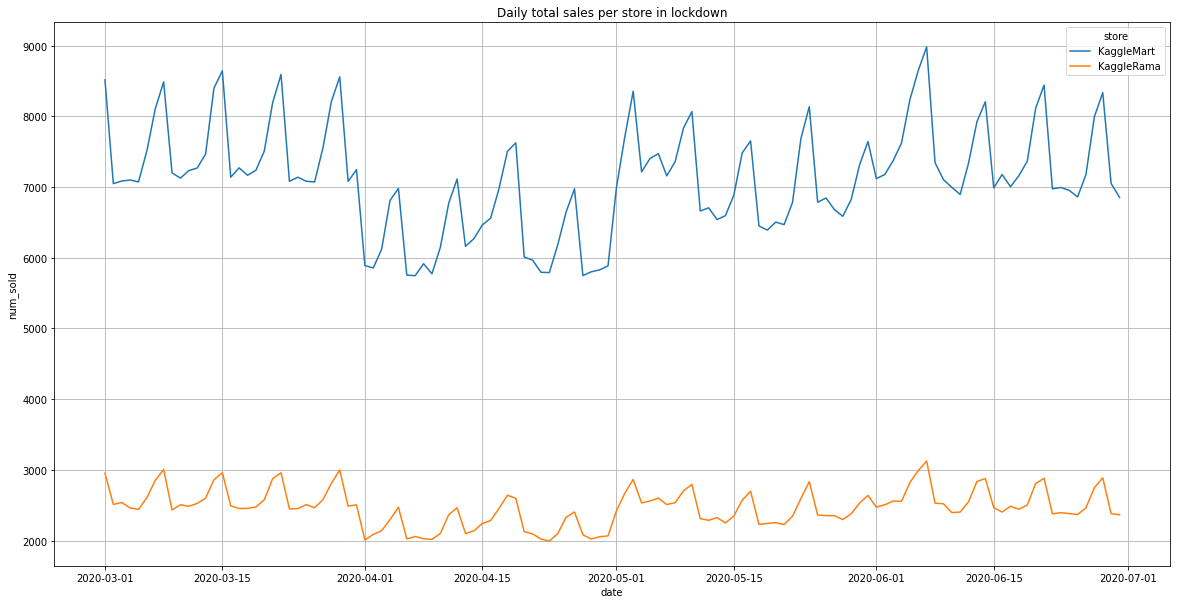

In [23]:
plt.figure(figsize=(20,10))
plt.grid()
plot2=Pandemy_on.groupby(by=["date","store"]).sum().reset_index()
sns.lineplot(data=plot2,x="date",y="num_sold", hue="store")
plt.title("Daily total sales per store in lockdown");

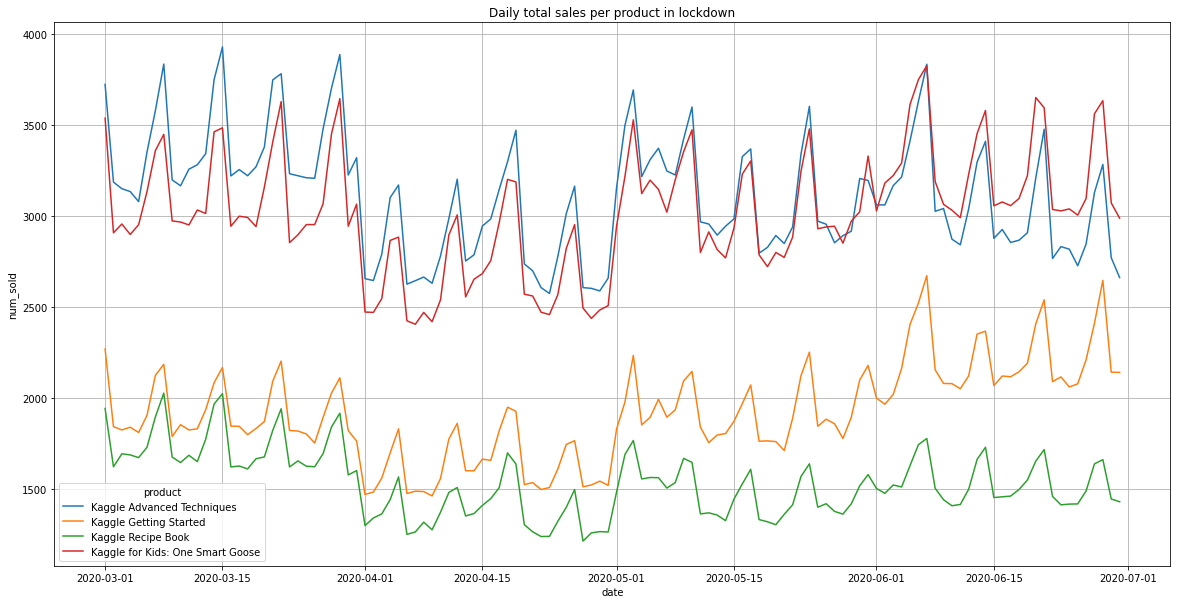

In [24]:
plt.figure(figsize=(20,10))
plt.grid()
plot3=Pandemy_on.groupby(by=["date","product"]).sum().reset_index()
sns.lineplot(data=plot3,x="date",y="num_sold", hue="product")
plt.title("Daily total sales per product in lockdown");

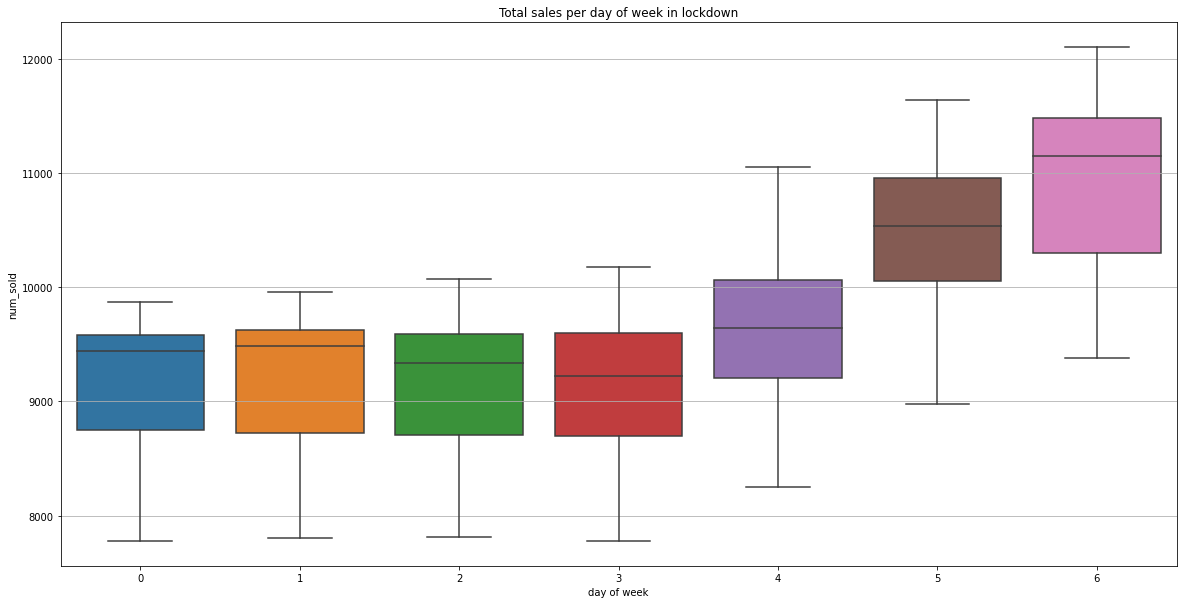

In [25]:
plt.figure(figsize=(20,10))
plt.grid()
plot3=Pandemy_on.groupby(by=["date","day of week"]).sum().reset_index()
sns.boxplot(data=plot3,x="day of week",y="num_sold")
plt.title("Total sales per day of week in lockdown");

In this context, the way to improve the model performance was to include the lockdown column for the model to be able to not consider these factors.

# Model construction

The main XGBoost model was built on the following steps:

1. Creation of Train and Test dataframes with one hot encoding by `pd.get_dummies` 
2. Training of a simple XGBRegressor with 1000 estimators and early stopping rounds for avoiding overfitting
3. Use of train and validation sets
4. Final prediction saving.

In [26]:
#Columns for modelings
columns=list(train.columns)
columns.remove("num_sold")
columns.remove("row_id")
columns.remove("date")
#One hot encoding
train_dummies=pd.get_dummies(train[columns],drop_first=True)
test_dummies=pd.get_dummies(test[columns],drop_first=True)
#Train - val split
x_train,x_test, y_train, y_test=train_test_split(train_dummies,train["num_sold"],
                                                 test_size=0.1, shuffle=False)
# XGBoost regressor
model = XGBRegressor(n_estimators=1000
                     ,n_jobs=-1,
                     early_stopping_rounds=40).fit(x_train,y_train,
                                                eval_set=[(x_train,y_train),(x_test,y_test)],
                                                verbose=50)
#Value Prediction
y_fin=list(model.predict(test_dummies))
#Final submission
submit=pd.read_csv("/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv")
submit
submit["num_sold"]=y_fin
submit.round().to_csv("submission.csv",index=False)

[0]	validation_0-rmse:162.42365	validation_1-rmse:187.11735
[50]	validation_0-rmse:14.73980	validation_1-rmse:27.94688
[100]	validation_0-rmse:13.03763	validation_1-rmse:26.77675
[150]	validation_0-rmse:12.34561	validation_1-rmse:26.20868
[200]	validation_0-rmse:11.91419	validation_1-rmse:26.13807
[250]	validation_0-rmse:11.62371	validation_1-rmse:25.93492
[300]	validation_0-rmse:11.39388	validation_1-rmse:25.89559
[324]	validation_0-rmse:11.30441	validation_1-rmse:25.88856


# Bonus - feature importance

The XGBRegressor has an additional tool that is to be able to show the importance of each of the considered variables on the model, presented in the following plot:

<AxesSubplot:>

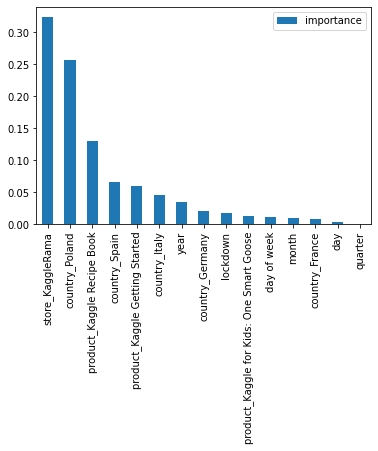

In [27]:
analysis=pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
                     columns=['importance'])
analysis.sort_values('importance',ascending=False).plot(kind="bar")